# Demo 

The parameters used in this script are defined in `params_demo.py`.

In [1]:
import os, sys
parentdir = os.path.dirname(os.path.dirname(os.path.realpath("./DeepHalos")))
sys.path.append(parentdir)
import numpy as np
from dlhalos_code import data_processing as tn
from dlhalos_code import CNN
import params_demo as params
import dlhalos_code.data_processing as tn
from pickle import dump
import matplotlib.pyplot as plt
from plots import plot_violins as pv
from plots import plots_for_predictions as pp

/Users/lls/anaconda/envs/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lls/anaconda/envs/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lls/anaconda/envs/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lls/anaconda/envs/3.7/lib/python3.7/site-packages/tensorf

In [2]:
path = "./demo-data/"

### Prepare the data

In [3]:
# Pre-process the simulation

sim_id = ["2"]
s = tn.SimulationPreparation(sim_id, path=path)

Loaded density array of simulation ID 2
Computing density contrast in simulation took 0.007171078523000082 minutes.


In [4]:
# Create a training set by drawing randomly from the simulation 11400 particles

training_set = tn.InputsPreparation(sim_id, shuffle=True, scaler_type="minmax", return_rescaled_outputs=True,
                                    output_range=(-1, 1), log_high_mass_limit=13.4,
                                    load_ids=False, random_style="random", random_subset_all=21400,
                                    path=path)

training_ids = training_set.particle_IDs[:6400]
validation_ids = training_set.particle_IDs[6400:11400]
test_ids = training_set.particle_IDs[11400:]

labels = training_set.labels_particle_IDS
scaler = training_set.scaler_output

In [5]:
# Create the data generators which are used as input to the model

generator_training = tn.DataGenerator(training_ids, labels, s.sims_dic, shuffle=True, **params.params_tr)
generator_validation = tn.DataGenerator(validation_ids, labels, s.sims_dic, shuffle=False, **params.params_val)
generator_test = tn.DataGenerator(test_ids, labels, s.sims_dic, shuffle=False, **params.params_val)

### Train the model using our custom Cauchy loss function

In [6]:
# Train the model using our custom Cauchy loss function for 30 epochs.

num_epochs = 30
Model = CNN.CNNCauchy(params.param_conv, params.param_fcc, model_type="regression", 
                      training_generator=generator_training, validation_generator=generator_validation,
                      shuffle=True, num_epochs=num_epochs, dim=generator_training.dim, initialiser="Xavier_uniform",
                      steps_per_epoch=len(generator_training), validation_steps=len(generator_validation),
                      max_queue_size=10, use_multiprocessing=False, workers=0, verbose=1, num_gpu=1, 
                      lr=params.lr, save_summary=True, path_summary=params.saving_path, validation_freq=1, 
                      train=True, compile=True, initial_epoch=None, lr_scheduler=False, seed=params.seed)

Initiating regression model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Initialiser is Xavier uniform
leaky relu
leaky relu
compiling
These are the final losses from the Cauchy model:
[<tf.Tensor 'conv3d/kernel/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'conv3d_1/kernel/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'conv3d_2/kernel/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'dense/kernel/Regularizer/add_1:0' shape=() dtype=float32>, <tf.Tensor 'dense_1/kernel/Regularizer/add_1:0' shape=() dtype=float32>]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
done compiling
Initial value of gamma is 0.20000
Start training with a linear activation in the last layer
Epoch 1/30
 99/100 [============================>.] - ETA: 0s - loss: 24.7864
Updated gamma to value 0.20468
100/100 [==============================] - 32s 322ms/step - loss: 24.7750

 99/100 [============================>.] - ETA: 0s - loss: 2.3913
Updated gamma to value 0.28868
100/100 [==============================] - 22s 217ms/step - loss: 2.3918 - val_loss: 2.3526
Epoch 30/30
 99/100 [============================>.] - ETA: 0s - loss: 2.2967
Updated gamma to value 0.29066
100/100 [==============================] - 22s 223ms/step - loss: 2.2973 - val_loss: 2.2619


In [7]:
# Check out what your model looks like

print(Model.model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 11, 11, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 11, 11, 11, 8)     224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 11, 11, 11, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 11, 11, 11, 8)     1736      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 11, 11, 8)     0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 6, 6, 8)        0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 6, 6, 6, 16)       3472

### Predict the final halo mass label for the validation set

In [8]:
# Predict the labels for the validation set from the model after 30 epochs

pred = Model.model.predict_generator(generator_test, use_multiprocessing=False, workers=0, verbose=1)
truth_rescaled = np.array([labels[ID] for ID in test_ids])

h_m_pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
true = scaler.inverse_transform(truth_rescaled.reshape(-1, 1)).flatten()

200/200 [==============================] - 11s 55ms/step


Text(0, 0.5, '$\\log \\left( M_\\mathrm{predicted}/\\mathrm{M}_\\odot\\right)$')

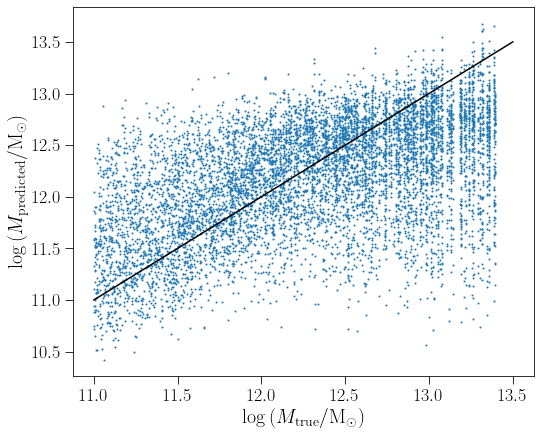

In [9]:
# Plot the predictions for the validation set as a scatter plot

f, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.plot([11, 13.5], [11, 13.5], color="k")
axes.scatter(true[true>=11], h_m_pred[true>=11], s=1)
axes.set_xlabel(r"$\log \left( M_\mathrm{true}/\mathrm{M}_\odot\right)$")
axes.set_ylabel(r"$\log \left( M_\mathrm{predicted}/\mathrm{M}_\odot\right)$")

[11.557199 11.674754 11.787257 11.966291 12.094232 12.202856 12.323935
 12.344615 12.390005 12.417933 12.461553 12.520137]


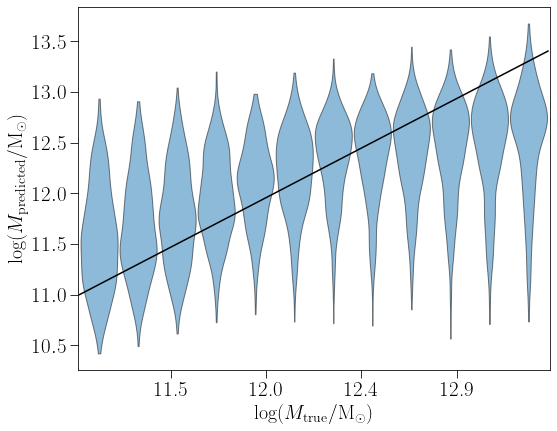

In [10]:
# Plot the predictions for the validation set as a violin plot

f1 = pv.plot_violin(true[true>=11], h_m_pred[true>=11], bins_violin=None,
                    return_stats=None, box=False, alpha=0.5, vert=True, col="C0", figsize=(8, 6))

In [11]:
# Plot the residuals for different mass bins of halos

TypeError: Input 'y' of 'Add' Op has type float64 that does not match type float32 of argument 'x'.

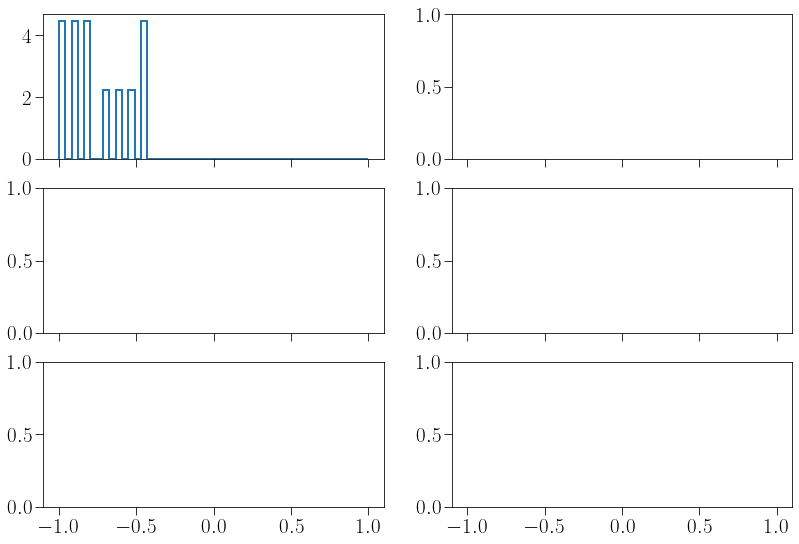

In [12]:
# Plot the likelihood fit 

# To run this cell, set "local_machine=True" in line 1 in `dlhalos_code/loss_functions.py` 
# and reload the module as here:
import importlib
from dlhalos_code import loss_functions as lf
importlib.reload(lf)

slices = [-0.85, -0.6, 0, 0.5, 0.75, 0.95]
gamma = Model.model.layers[-1].get_weights()[0][0]
f, a = pp.plot_likelihood_distribution(h_m_pred, true, gamma, scaler, bins=np.linspace(-1,1,50), fig=None, axes=None,
                                       title=None, legend=True, slices=slices)